# Trial Analysis

`-- Leo Lonzarich, 6 January 2021 // [Revised 15-3-23] --`

Trial code used to demonstrate effectiveness of analytic package using TSlA as proxy.


### Table of Contents
- [Importing Data](#import)
 


### Motivations:
- What is the change in stock price relative to other markets over time?

- How does this stock correlate and compare to other relevant stocks

- What is the daily return of a stock on average?

- What does the moving average tell us about a stock?

- What is the financial risk of investing in a particular equity?


### General Comments:
- This notebook is meant be an elementary -- but comprehensive -- analysis of user-selected stocks and serve as a gateway to the `Stock_Predictions` notebook, informing us of the most promising equities to forecast (and prehaps invest in). 

    - Analysis on predictions will be covered separately in `Stock_Predictions`.
<br><br>

- This project, and the analysis herein, is meant only to be a supplemental tool alongside general intuition, good sense, analysis of financial climates, etc.

<br><br>

---
#### TODO
- Restructure the notebook.

- Update data importing.

- Address the questions in 'motivations'.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

import optuna

from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt

# Yahoo API may have broken previous versions of pd_datareader, so this is a workaround.
yfin.pdr_override()
pd.options.mode.chained_assignment = None  # default='warn'


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing Data:<a class="anchor" id="import"></a>
---

We use yfinance here, with a pandas_datareader workaround to address loss of yfinance API. 

For the purposes of this analysis, we will be using adjusted daily closing prices (versus closing price). Since we want to predict future stock performance, closing prices are the natural choice as a predictive metric. Furthermore adjusted price gives stock price after dividend payounts, stock splits, and/or additional share issues, resulting in a more realistic and data-rich representation of share value.

In [3]:
# Yahoo Finance stock scraping.
# **Careful with how many times you run this to avoid IP ban**
TICKER = 'AMZN'
START = dt.datetime(2012, 1, 1)
END = dt.datetime.today()

stock = pdr.get_data_yahoo(TICKER, START, END).rename(columns= {'Adj Close': 'AdjClose'})

print(stock.shape[0], "unique points loaded with attributes: \n", stock.
      keys())

[*********************100%***********************]  1 of 1 completed
2818 unique points loaded with attributes: 
 Index(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')


In [4]:
stock.head()

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2012-01-03,8.7945,8.9740,8.7775,8.9515,8.9515,102216000
2012-01-04,8.9605,9.0250,8.8035,8.8755,8.8755,84104000
2012-01-05,8.7970,8.9125,8.7025,8.8805,8.8805,76182000
2012-01-06,8.9035,9.2325,8.8750,9.1305,9.1305,140168000
2012-01-09,9.1380,9.2185,8.8500,8.9280,8.9280,101138000


In [5]:
# Use applymap to reduce tabular clutter.
stock.describe().applymap(lambda x: f"{x:0.3f}")

,Open,High,Low,Close,AdjClose,Volume
count,2818.000,2818.000,2818.000,2818.000,2818.000,2818.000
mean,68.635,69.427,67.757,68.605,68.605,80415418.417
std,53.619,54.276,52.886,53.568,53.568,42741671.340
min,8.691,8.913,8.600,8.797,8.797,17626000.000
25%,18.024,18.285,17.867,18.093,18.093,53824725.000
50%,49.246,49.568,48.791,49.133,49.133,69029350.000
75%,98.555,99.871,97.420,98.739,98.739,92962500.000
max,187.200,188.654,184.839,186.570,186.570,477122000.000


In [6]:
stock.isnull().values.any()

False

To really see what we are working with, let's plot the adjusted closing price below over the time frame we specified.

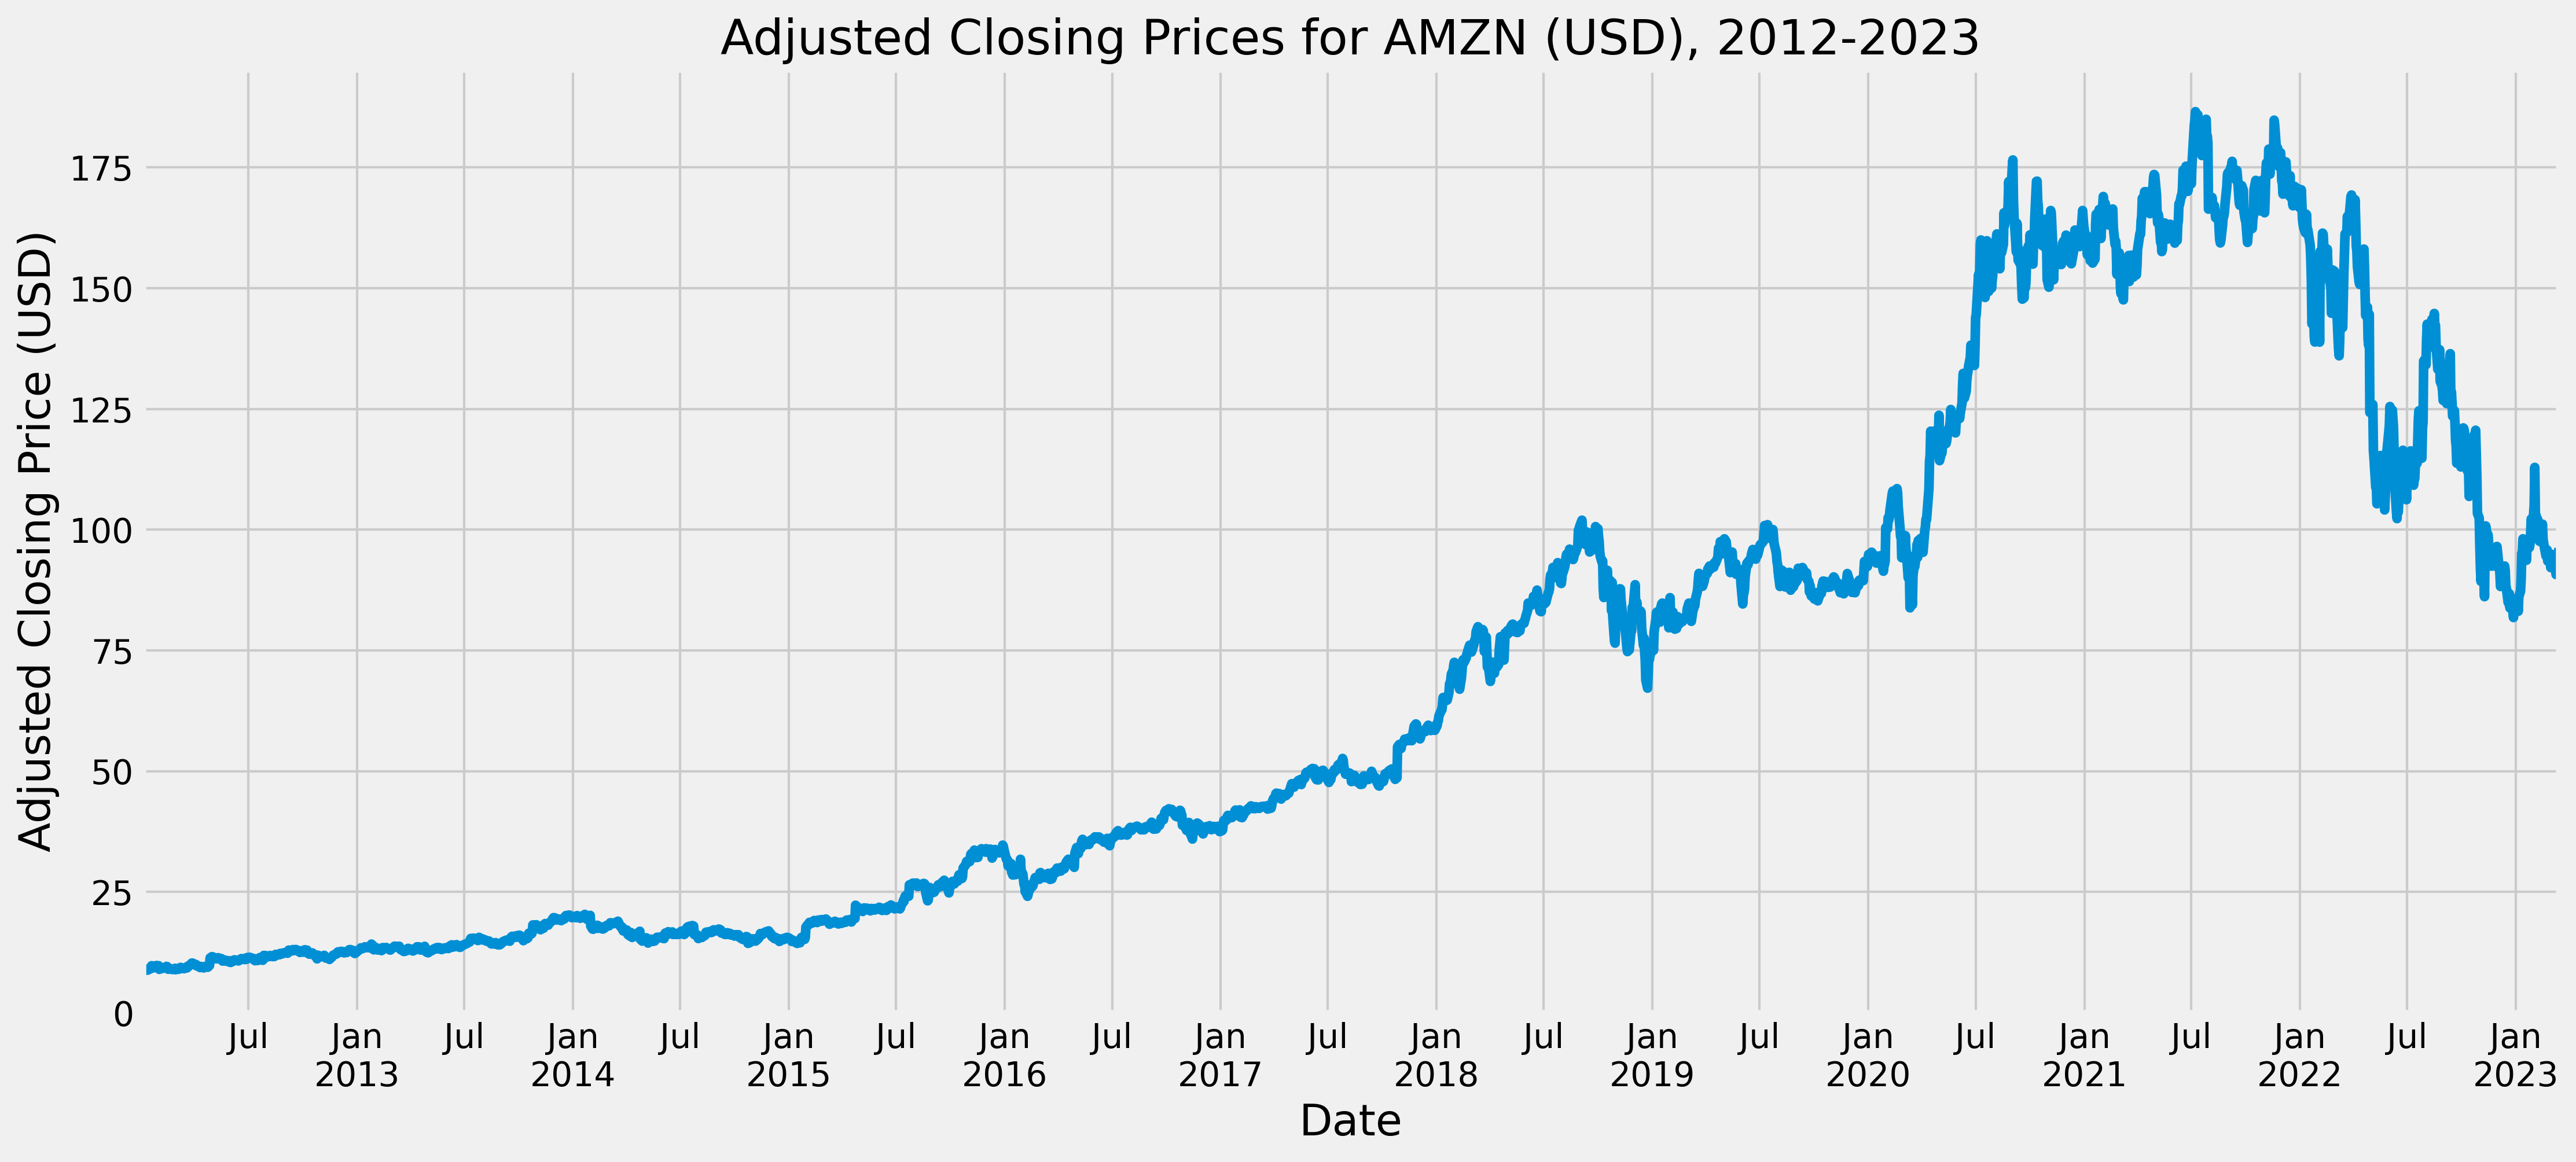

In [7]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.index, stock.AdjClose)

ax.set_title('Adjusted Closing Prices for %s (USD), %s-%s' 
             %(TICKER, START.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

### Beta Calculation:<a class="anchor" id="beta"></a>

One of the questions we seek to answer here is to what degree multivariate LSTM is enhanced over univariate LSTM. That is, do we enhance predictive power by including metrics like beta, volume, CAPE, PE?

To this end, for each day in our `stock` dataframe, we calculate beta with the previous year of adjusted closing prices and append them to the dataframe using a roll generator from linalg to improve efficiency. Following this method, the first year's worth of stock data should not include any betas. 

Ideally, beta should be calculated with a market that is highly correlated with the target stock. For the case of most tech stocks, the SPY index should work handily.

(Recall above that there are $\sim$ 255 market days per year.)

In [ ]:
# Specify number of days to use for beta calculation (255 = 1yr).
window = 252 

# Specify a market highly correlated with 'stock'.
market_ticker = 'SPY'

def beta(df, market=None):
    # If the market values are not passed,
    # I'll assume they are located in a column
    # named 'Market'.  If not, this will fail.
    if market is None:
        market = df['MarketClose']
        df = df.drop('MarketClose', axis=1)
    X = market.values.reshape(-1, 1)
    X = np.concatenate([np.ones_like(X), X], axis=1)
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values)
    return float(b[1])

def roll(df, w=252):
    # Takes 'w'-sized slices from dataframe, incrementing 1 entry at a time.
    for i in range(df.shape[0] - w + 1):
        yield pd.DataFrame(df.values[i:i+w, :], df.index[i:i+w],
                           df.columns)


#### Combining stock + market data and computing.
market = pdr.get_data_yahoo(market_ticker,
                            START,
                            END).rename(columns={'Adj Close': 'MarketClose'})

betas = np.array([])
data = pd.concat([stock.AdjClose, market.MarketClose], axis=1)

for  i, sdf in enumerate(roll(data.pct_change().dropna(), window)):
    betas = np.append(betas, beta(sdf))

data_added = data.drop(index=data.index[:window], axis=0, inplace=False)
data_added['Beta'] = betas.tolist()

Let's plot the stock and correlated market side by side, and include the rolling beta calculation for reference.

In [ ]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.index, stock.AdjClose, label=TICKER)
ax.plot(market.index, market.MarketClose, label=market_ticker + ' (Market)')
ax.plot(data_added.index, data_added.Beta*50, linestyle='-', label='1Yr Relative Beta')


ax.set_title('Adjusted Closing Prices for %s and %s (USD), %s-%s' 
             %(TICKER, market_ticker, START.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)
ax.legend()

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

plt.show()

^^^^^^^^^^ Everything above is good

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

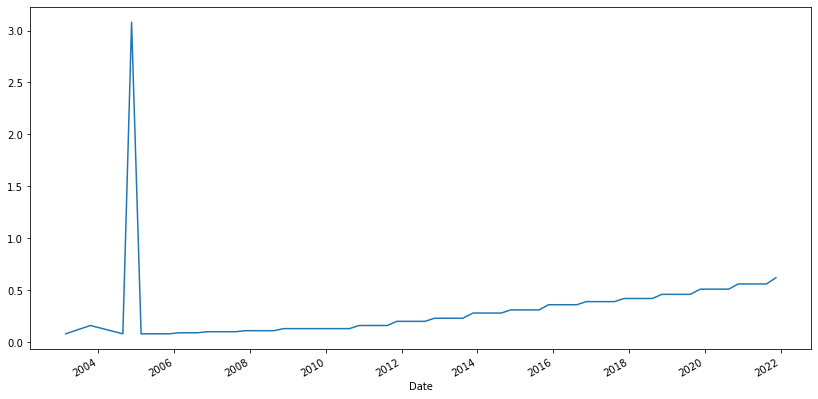

In [19]:
# pulling dividends for MSFT.
msft = yf.download('MSFT', start='2018-11-01', end='2021-12-22', interval='1d')

t = yf.Ticker('msft')
t.dividends.plot(figsize=(14,7))

## Moving Average (MA)

---
- Identifies the direction of a current price trend, ignoring short-term price spikes.

- Used to identify significant support and resistance levels.

- Stan Weinstein: Price must be above short term MA to buy a stock.

In [5]:
tsla.Close.rolling(20).mean()

Date
2018-11-01            NaN
2018-11-02            NaN
2018-11-05            NaN
2018-11-06            NaN
2018-11-07            NaN
                 ...     
2021-12-15    1065.702502
2021-12-16    1057.598001
2021-12-17    1049.407501
2021-12-20    1037.551498
2021-12-21    1026.634500
Name: Close, Length: 790, dtype: float64

<AxesSubplot:xlabel='Date'>

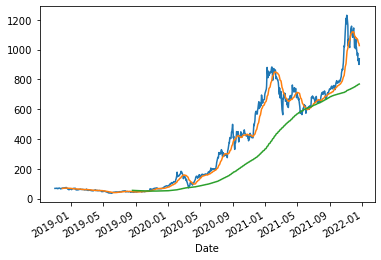

In [38]:
tsla.loc[:, 'ma20'] = tsla.Close.rolling(20).mean() #20-day MA.
tsla.loc[:, 'ma200'] = tsla.Close.rolling(200).mean() #200-day MA.

tsla.Close.plot() # actual closing.
tsla.loc[:, 'ma20'].plot()
tsla.loc[:,'ma200'].plot()

## Relative Strength Index (RSI)

---
- Momentum indicator